# Redes Neuronales Convolucionales con PyTorch

"Aprendizaje profundo" es un término general que generalmente se refiere al uso de redes neuronales con múltiples capas que sintetizan la forma en que el cerebro humano aprende y toma decisiones. Una red neuronal convolucional es un tipo de red neuronal que extrae *características* de matrices de valores numéricos (a menudo imágenes) mediante la convolución de múltiples filtros sobre los valores de matriz para aplicar pesos e identificar patrones, como bordes, esquinas, etc. imagen. Las representaciones numéricas de estos patrones luego se pasan a una capa de red neuronal completamente conectada para asignar las características a clases específicas.

Hay varios marcos de trabajo comúnmente utilizados para crear CNN. En este cuaderno, crearemos una CNN de ejemplo simple usando PyTorch.

## Importar bibliotecas

Primero, instalemos e importemos las bibliotecas de PyTorch que necesitaremos.

In [29]:
# Librerias de PyTorch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Otras librerias 
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print('Librerias importadas - listo para usar PyTorch', torch.__version__)


Librerias importadas - listo para usar PyTorch 1.11.0+cpu


# Exploracion de datos 

En este ejercicio, entrenará un modelo de clasificación basado en CNN que puede clasificar imágenes de formas geométricas. Echemos un vistazo a las clases de forma que el modelo necesita identificar.

3, classes
['circle', 'square', 'triangle']


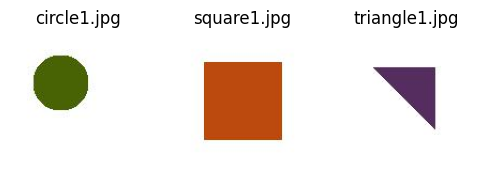

In [30]:
# Las imagenes se encuentran en este folder 'data/shapes/'
data_path = 'data/shapes/'

# Obtenemos el nombre de las clases
classes = os.listdir(data_path)     # Nombres de las clases
classes.sort()                      # Ordenamos
print(f'{len(classes)}, classes')
print(classes)

# Mostrar la primera imagen en cada carpeta
fig = plt.figure(figsize=(6,6))
i = 0

for sub_dir in os.listdir(data_path):
    i += 1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]   # Archivo
    img_path = os.path.join(data_path, sub_dir, img_file)       # Ubicacion del archivo
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()


## Cargar datos

PyTorch incluye funciones para cargar y transformar datos. Los usaremos para crear un cargador iterativo para datos de entrenamiento y un segundo cargador iterativo para datos de prueba (que usaremos para validar el modelo entrenado). Los cargadores transformarán los datos de la imagen en *tensores*, que son la estructura de datos central utilizada en PyTorch, y los normalizarán para que los valores de los píxeles estén en una escala con una media de 0,5 y una desviación estándar de 0,5.

Ejecute la siguiente celda para definir los cargadores de datos.

In [31]:
# Función para ingerir datos usando cargadores de entrenamiento y prueba
def load_dataset(data_path):
    # Cargamos todas las imagenes
    transfomation = transforms.Compose([
        transforms.ToTensor(),       # Transformamos a tensores
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalizamos los valores de los pixeles (canales R,G Y B)        
    ])

    # Cargamos todas las imagenes, transformandolas
    full_dataset = torchvision.datasets.ImageFolder(
        root= data_path,            # ubicacion
        transform=transfomation     # transformacion
    )

    # Dividir en conjuntos de datos de entrenamiento (70 % y prueba (30 %)
    train_size = int(0.7*len(full_dataset))
    test_size  = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    # definir un cargador para los datos de entrenamiento que podemos iterar en lotes de 50 imágenes
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    # definir un cargador para los datos de prueba que podemos recorrer en lotes de 50 imágenes
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader

# obtener los dataloadres interactivos para datos de prueba y entrenamiento
train_loader, test_loader = load_dataset(data_path)
print('Datos Cargados')

Datos Cargados


# Definimos la CNN

En PyTorch, define un modelo de red neuronal como una clase que se deriva de la clase base **nn.Module**. Su clase debe definir las capas en su red y proporcionar un método de **reenvío** que se utiliza para procesar datos a través de las capas de la red.

In [32]:
# Definimos la clase

class Net(nn.Module):

    # Constructor
    def __init__(self, num_classes = 3):
        super(Net, self).__init__()

        # Nuestras imágenes son RGB, por lo que los canales de entrada = 3. Aplicaremos 12 filtros en la primera capa convolucional
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride= 1, padding= 1)

        # Aplicaremos la agrupación máxima con un tamaño de kernel de 2
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Una segunda capa convolucional toma 12 canales de entrada y genera 12 salidas
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)

        # Una tercerca capa convolucional toma 12 canales de entrada y genera 24 salidas
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

        # Una capa de anulacion que ayuda a eliminar el 20% de las caracteristicas para evitar el sobreajuste
        self.drop = nn.Dropout2d(p=0.2)

        # Nuestros tensores de imagen de 128x128 se agruparán dos veces con un tamaño de kernel de 2. 128/2/2 es 32.
        # Así que nuestros tensores de características ahora son 32 x 32, y hemos generado 24 de ellos
        # Necesitamos aplanarlos y alimentarlos a una capa completamente conectada
        # para asignarlos a la probabilidad de cada clase
        self.fc = nn.Linear(in_features=32*32*24, out_features=num_classes)
    
    def forward(self,x):
        # Use una función de activación de relu después de la capa 1 (convolución 1 y grupo)
        x = F.relu(self.pool(self.conv1(x)))
        
        # Use una función de activación de relu después de la capa 2 (convolución 2 y grupo)
        x = F.relu(self.pool(self.conv2(x)))

        # Seleccione algunas características para colocarlas después de la tercera convolución para evitar el sobreajuste
        x = F.relu(self.drop(self.conv3(x)))

        # Solo elimine las funciones si se trata de un pase de entrenamiento
        x = F.dropout(x, training=self.training)

        # aplanar
        x = x.view(-1, 32*32*24)

        # Alimentar a la capa completamente conectada para predecir la clase
        x = self.fc(x)

        # Devuelve el tensor log_softmax
        return F.log_softmax(x, dim= 1)

print('CNN - modelo de clasificacion definido!')


CNN - modelo de clasificacion definido!


## Entrenar al modelo

Ahora que hemos definido una clase para la red, podemos entrenarla usando los datos de la imagen.

El entrenamiento consiste en una serie iterativa de pases hacia adelante en los que las capas de la red procesan los datos de entrenamiento en lotes, y el optimizador retrocede y ajusta los pesos. También usaremos un conjunto separado de imágenes de prueba para probar el modelo al final de cada iteración (o *época*) para que podamos realizar un seguimiento de la mejora del rendimiento a medida que avanza el proceso de capacitación.

En el siguiente ejemplo, usamos 5 épocas para entrenar el modelo usando los lotes de imágenes cargados por los cargadores de datos, reteniendo los datos en el cargador de datos de prueba para su validación. Después de cada época, una función de pérdida mide el error (*pérdida*) en el modelo y ajusta los pesos (que se generaron aleatoriamente para la primera iteración) para tratar de mejorar la precisión.

> **Nota**: Solo estamos usando 5 épocas para minimizar el tiempo de entrenamiento para este ejemplo simple. Una CNN del mundo real generalmente se entrena en más épocas que esta. El entrenamiento del modelo CNN requiere un uso intensivo del procesador, lo que implica muchas operaciones basadas en matrices y vectores; por lo que se recomienda realizar esto en un sistema que pueda aprovechar las GPU, que están optimizadas para este tipo de cálculo. Esto tardará un tiempo en completarse en un sistema basado en CPU: el estado se mostrará a medida que avanza el entrenamiento.

In [33]:
def train(model, device, train_loader, optimizer, epoch):

    model.train()   # Establecemos el modelo en modo entrenamiento
    train_loss = 0
    print('Epoch:', epoch)

    # Procesamos las imagenes por lotes 
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use la CPU o la GPU según corresponda
        data, target = data.to(device), target.to(device)

        # Reestablecemos el optimizador
        optimizer.zero_grad()

        # Empuje los datos hacia adelante a través de las capas del modelo
        output = model(data)

        # Obtener la perdida
        loss = loss_criteria(output, target)

        # Mantener un total acumulado
        train_loss += loss.item()

        # Retropropagacion
        loss.backward()
        optimizer.step()
        
        # Imprima métricas por cada 10 lotes para que veamos algún progreso
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # devuelve la pérdida promedio para la época
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # si la GPU está disponible, use cuda (en una CPU, ¡el entrenamiento tomará un tiempo considerable!)
    device = "cuda"
print('Training on', device)

# Cree una instancia de la clase modelo y asígnela al dispositivo
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 5
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/840 (0%)] Loss: 1.094503
Training set [500/840 (59%)] Loss: 0.908985
Training set: Average loss: 0.960145
Validation set: Average loss: 0.645471, Accuracy: 267/360 (74%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.718209
Training set [500/840 (59%)] Loss: 0.428012
Training set: Average loss: 0.503786
Validation set: Average loss: 0.316891, Accuracy: 310/360 (86%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.338187
Training set [500/840 (59%)] Loss: 0.224213
Training set: Average loss: 0.298347
Validation set: Average loss: 0.217537, Accuracy: 328/360 (91%)

Epoch: 4
Training set [0/840 (0%)] Loss: 0.261548
Training set [500/840 (59%)] Loss: 0.138442
Training set: Average loss: 0.170777
Validation set: Average loss: 0.094481, Accuracy: 358/360 (99%)

Epoch: 5
Training set [0/840 (0%)] Loss: 0.074345
Training set [500/840 (59%)] Loss: 0.075966
Training set: Average loss: 0.073747
Validation set: Average loss: 0.041357, Accuracy: 358/360 (99%)



## Ver el historial de pérdidas

Hicimos un seguimiento de la pérdida promedio de entrenamiento y validación para cada época. Podemos graficarlos para verificar que la pérdida se redujo a medida que se entrenó el modelo y para detectar *sobreajuste* (que se indica por una caída continua en la pérdida de entrenamiento después de que la pérdida de validación se niveló o comenzó a aumentar).

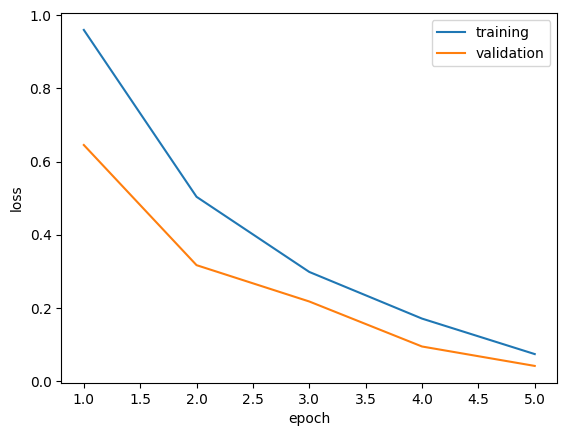

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Evaluar el rendimiento del modelo

Puede ver la precisión final en función de los datos de prueba, pero normalmente querrá explorar las métricas de rendimiento con un poco más de profundidad. Tracemos una matriz de confusión para ver qué tan bien el modelo predice cada clase.

Getting predictions from test set...


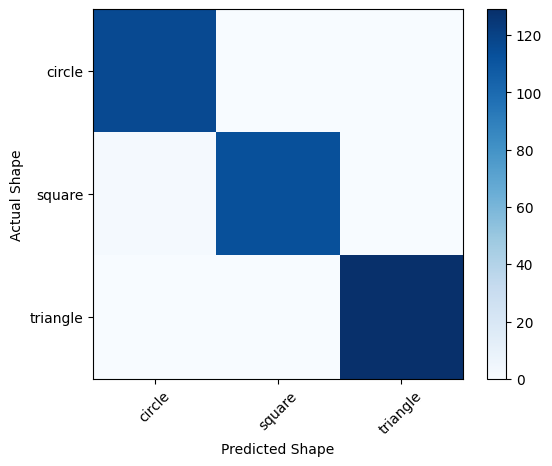

In [35]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Guardar el modelo entrenado

Ahora que ha entrenado un modelo de trabajo, puede guardarlo (incluidos los pesos entrenados) para usarlo más tarde.

In [36]:
# Save the model weights
model_file = 'models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as models/shape_classifier.pt


## Usar el modelo entrenado

Ahora que hemos entrenado y evaluado nuestro modelo, podemos usarlo para predecir clases para nuevas imágenes.

square


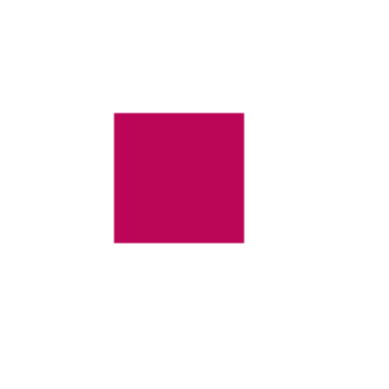

In [38]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.axis('off')
plt.imshow(img)

# Create a new model class and load the saved weights
model = Net()
model.load_state_dict(torch.load(model_file))

# Call the predction function
index = predict_image(model, img)
print(classes[index])

## Otras lecturas

Para obtener más información sobre el entrenamiento de redes neuronales convolucionales con PyTorch, consulte la [documentación de PyTorch] (https://pytorch.org/).

## Desafío: clasificación de imágenes de Safari

Esperamos que este cuaderno le haya mostrado los pasos principales para entrenar y evaluar una CNN. ¿Por qué no pones en práctica lo que has aprendido con nuestro desafío de clasificación de imágenes de Safari en el cuaderno [/challenges/05 - Safari CNN Challenge.ipynb](./challenges/05%20-%20Safari%20CNN%20Challenge.ipynb)?

> **Nota**: El tiempo para completar este desafío opcional no está incluido en el tiempo estimado para este ejercicio. ¡Puedes dedicarle el tiempo que quieras!